# Combining Machine Learned and Empircal Energy Functions

In [200]:
import os
os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"

# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [201]:
from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import _prepare_batches as prepare_batches #prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc

def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


def calc_physnet(atomic_numbers, atom_positions, ase_calc_monomer, ase_calc_dimer, dimer_permutations=[(1,2)]):

    ase_monomers_dict = {}
    e_monomers_dict = {}
    for i in range(20):
        start, stop = i*5, i*5 + 5
        Z, R = atomic_numbers, atom_positions
        Z = [_ for i, _ in enumerate(Z) if start <= i < stop  ]
        R = [_ for i, _ in enumerate(R) if start <= i < stop  ]
        ase_atoms_monomer = ase.Atoms(Z, R)
        ase_atoms_monomer.calc = ase_calc_monomer
        ase_monomers_dict[i] = ase_atoms_monomer
        e_monomers_dict[i] = ase_atoms_monomer.get_potential_energy()
        
    monomer_atom_energies = sum( [Eref[z] for z in ase_atoms_monomer.get_atomic_numbers()])
    monomer_atom_energies, ase_atoms_monomer.get_atomic_numbers()
    
    ase_dimers_dict = {}
    e_dimers_dict = {}
    
    for perm in dimer_permutations:
        a,b = perm
        monomer1 = ase_monomers_dict[a]
        monomer2 = ase_monomers_dict[b]
        ase_atoms_dimer = monomer1 + monomer2
        ase_atoms_dimer.calc = ase_calc_dimer
        ase_dimers_dict[i] = ase_atoms_dimer
        e_dimers_dict[perm] = ase_atoms_dimer.get_potential_energy()
    
    eint_dimers_dict = {}
    
    for perm in dimer_permutations:
        a,b = perm
    
        tot_e_dimer = e_dimers_dict[perm] 
        monomer1_tot_e = e_monomers_dict[a]
        monomer2_tot_e = e_monomers_dict[b]
        eint_dimers_dict[perm] = tot_e_dimer - (monomer1_tot_e + monomer2_tot_e)
    
    sum_of_monomers = float(sum(list(e_monomers_dict.values())))
    sum_of_dimers = float(sum(list(e_dimers_dict.values())))
    
    dimer_intE = float(sum(list(eint_dimers_dict.values())))
    sum_of_monomers_total_e = monomer_atom_energies*20 + sum_of_monomers / 627.509
    return {"dimer_intE": dimer_intE, "sum_of_monomers_total_e": sum_of_monomers_total_e}

# set reference atomic energies

In [202]:
Eref = np.zeros([20], dtype=float)
Eref[1] = -0.498232909223
Eref[6] = -37.731440432799
Eref[8] = -74.878159582108
Eref[17] = -459.549260062932

# Fitting the ML model

In [9]:
NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)

In [10]:
files = [
    Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"),

]

In [ ]:
restart = None
if RESTART_ML:
    restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"


if TRAIN_ML:
    train_data, valid_data = prepare_datasets(
        data_key,
        16800,
         4199,
        files,
        clip_esp=False,
        natoms=NATOMS,
        clean=False,
        subtract_atom_energies=False,
        verbose=True,
    )
    
    ntest = len(valid_data["E"]) // 2
    test_data = {k: v[ntest:] for k, v in valid_data.items()}
    valid_data = {k: v[:ntest] for k, v in valid_data.items()}

    DEFAULT_DATA_KEYS = ["Z", "R", "D", "E", "F", "N"]
    batch_size = 10
    
    test_batches = prepare_batches(data_key, test_data, batch_size,
                                  num_atoms=NATOMS, 
                                  data_keys=DEFAULT_DATA_KEYS)
    
    train_batches = prepare_batches(data_key, train_data, batch_size,
                                  num_atoms=NATOMS, 
                                  data_keys=DEFAULT_DATA_KEYS)
    
    valid_batches = prepare_batches(data_key, valid_data, batch_size,
                                  num_atoms=NATOMS, 
                                  data_keys=DEFAULT_DATA_KEYS)
    
    params = train_model(
        train_key,
        model,
        train_data,
        valid_data,
        num_epochs=int(1e6),
        learning_rate=0.0001,
        energy_weight=1,
        dipole_weight=1,
        charges_weight=1,
        forces_weight=1,
        schedule_fn="constant",
        optimizer="amsgrad",
        batch_size=batch_size,
        num_atoms=NATOMS,
        data_keys=DEFAULT_DATA_KEYS,
        restart=restart,
        name="dichloromethane",
        print_freq=1,
        objective="valid_loss",
        best=1e6,
        batch_method="default",
    )

if ANALYSE_ML:
    output = plot_stats(test_batches, model, params, _set="Test", 
                   do_kde=True, batch_size=batch_size)

# Analysing the fit of the model

In [ ]:
_ = plt.hist(output["Es"] - output["predEs"], bins=100)
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-800, -750)
plt.ylim(-800, -750)
plt.plot([-800, -750], [-800, -750])
plt.show()
plt.scatter(output["Es"] , output["predEs"], alpha=0.1)
plt.xlim(-390, -375)
plt.ylim(-390, -375)
plt.plot([-390, -375], [-390, -375])

In [207]:
import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm



import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view

ev2kcalmol = 1/(ase.units.kcal / ase.units.mol)


def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)

def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)
    
    with open("total.dmat") as f:
        output_dmat = f.read()
    
    atom_number_type_dict = {}
    atom_number_resid_dict = {}
    
    pair_distance_dict = {}
    pair_resid_dict = {}
    
    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()
        
            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1
            
    for _ in output_dmat.split("\n"):        
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if (atom_number_resid_dict[a] < atom_number_resid_dict[b]):
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (atom_number_resid_dict[a], atom_number_resid_dict[b])

    return     {"atom_number_type_dict" : atom_number_type_dict,
    "atom_number_resid_dict" : atom_number_resid_dict,
    "pair_distance_dict" : pair_distance_dict,
    "pair_resid_dict" : pair_resid_dict,}

def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces

def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations

def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations

def calc_pycharmm_dimers(n_mol = 20):
    
    RANGE = len(dimer_permutations(n_mol))
    
    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    
    for i, (a,b) in enumerate(dimer_permutations(20)):
        a += 1
        b += 1
        print(a, b)
        block = f"""BLOCK 2
        CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
          CALL 2 SELE (RESID {a} .OR. RESID {b}) END
          COEFF 1 1 0.0
          COEFF 2 2 1.0
          COEFF 1 2 0.0
        END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        # energy.show()
        
        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {"ele_energies": ele_energies, "evdw_energies": evdw_energies}

def reset_block():
        block = f"""BLOCK 1
        CALL 1 SELE ALL END
          COEFF 1 1 1.0
        END
        """
        _ = pycharmm.lingo.charmm_script(block)

reset_block()

  
 CHARMM>     BLOCK 1
 Block structure initialized with   1 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
 Matrix of VDW Interaction Coefficients
 
    1.00000
  
 CHARMM>     
  


In [214]:
import MDAnalysis as mda

def load_pdb_data(pdb_file):
    loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array([ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names])
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {(a-1,b): i for i, (a,b) in enumerate(zip(mda_resids, atom_names))}
    charmm_res_at_dict = {(a,b): i for i, (a,b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k,v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k,v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array([charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))])
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

   
    return {"atom_names" : atom_names,
    "atom_positions" : atom_positions,
    "atomic_numbers" : atomic_numbers,
    "mda_resids" : mda_resids,
    "mda_res_at_dict" : mda_res_at_dict,
    "charmm_res_at_dict" : charmm_res_at_dict,
    "an_charmm_res_at_dict" : an_charmm_res_at_dict,
    "an_mda_res_at_dict" : an_mda_res_at_dict,
    "atom_positions" : atom_positions,
    "reorder" : reorder,
    "atom_positions" : atom_positions,
    "atomic_numbers" : atomic_numbers,
    }

def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda

In [216]:
pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)

pycharmm.lingo.charmm_script(load_dcm)

energy.show()
vdw = energy.get_vdw()
elec = energy.get_elec()

  
 CHARMM>     
  
 CHARMM>    set base     /pchem-data/meuwly/boittier/home/dcm-lj-data
 Parameter: BASE <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>    set pardir   @base
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 Parameter: PARDIR <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>    set crddir   @base
 Parameter: BASE -> "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
 Parameter: CRDDIR <- "/PCHEM-DATA/MEUWLY/BOITTIER/HOME/DCM-LJ-DATA"
  
 CHARMM>     
  
 CHARMM>    PRNLev 5
  
 CHARMM>     
  
 CHARMM>     
  
 CHARMM>    read rtf card
 MAINIO> Residue topology file being read from unit  90.
 RDTITL> * METHANOL
 RDTITL> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
  
 CHARMM>     
  
 CHARMM>    read parameter card

          PARAMETER FILE BEING READ FROM UNIT 90
 RDTITL> * METHANO

# Load the restarts

In [34]:
from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-af722a47-a3a3-4f31-987f-c6a9ab2fb555"
# restart = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d8bc5d79-f65e-451e-8169-bf6da5170b54"
restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"

restart = get_last(restart_path)
params, dimer_model = get_params_model(restart)
dimer_model.natoms = 10
print(dimer_model)



/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 10
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [35]:
restart = get_last(restart_path)
params, monomer_model = get_params_model(restart)
monomer_model.natoms = 5
print(monomer_model)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 18
    charges = True
    natoms = 5
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)


In [36]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 5  ]
R = [_ for i, _ in enumerate(R) if i < 5  ]
ase_atoms_monomer = ase.Atoms(Z, R)
# view_atoms(ase_atoms_monomer)

In [37]:
# TODO: add default keys to the conversion dict
ase_calc_monomer = get_ase_calc(params, monomer_model, ase_atoms_monomer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})
ase_atoms_monomer.calc = ase_calc_monomer
float(ase_atoms_monomer.get_potential_energy())

-385.333251953125

In [38]:
Z, R = atomic_numbers, atom_positions
Z = [_ for i, _ in enumerate(Z) if i < 10  ]
R = [_ for i, _ in enumerate(R) if i < 10  ]
ase_atoms_dimer = ase.Atoms(Z, R)
ase_calc_dimer = get_ase_calc(params, dimer_model, ase_atoms_dimer, conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol})
# view_atoms(ase_atoms_dimer)

# Charmm PSF data

In [217]:
atypes = psf.get_atype()
atc = pycharmm.param.get_atc()
residues = psf.get_res()
psf.get_natom()

# TODO: this assumes a pure system, need to update
atoms_per_res = int(len(atypes) / len(residues))
n_res = len(residues)
resids = np.array([[i]*atoms_per_res for i in range(n_res)]).flatten()


# Data 

In [40]:
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df

Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)  
0                    -41.731854  
1                    -42.949509  
2                    -39.747275  
3                    -35.855129  
4                    -31.547863  
..                          ...  
95                   -40.382115  
96                   -37.069863  
97                   -38.435091  
98                   -40.527012  
99                   -40.527012  

[100 rows x 5 columns]

In [41]:
fn = "100_lig_1_modified.pdb"
pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = pdb_data_mda["atomic_numbers"], pdb_data_mda["atom_positions"]
set_pycharmm_xyz(atom_positions)
energy.show()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    RDIElec  SWITch   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  =  8.000 CTEXNB =999.000 CTONNB =  6.500 CTOFNB =  7.500
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are     1989 atom  pairs and      200 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.

      ***** LEVEL  1 WARNING FROM <GTNBCT> *****
      ***** CUTNB and CTOFNB are too close for efficient heuristic update.
      ******************************************
      BOMLEV (  0) IS NOT REACHED. WRNLEV IS  5

 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR     4901 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
     1989 ATOM PAIRS WERE FOUND FOR ATOM LIST
      139 GROUP PAIRS REQUIRED ATOM SEARCHES

ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       A

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [63]:
ase_atoms = ase.Atoms(atomic_numbers, atom_positions)

# ase_atoms = ase.Atoms(atomic_numbers, forces.to_numpy())

view_atoms(ase_atoms)

# Load the pdb files

In [219]:
fn = "100_lig_1_modified.pdb"


In [220]:
pdb_data_mda = get_data_mda(fn)

In [221]:
# pdb_data_mda

In [222]:
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper() )
df

Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)          key  
0                    -41.731854    100_LIG_1  
1                    -42.949509   100_LIG_10  
2                    -39.747275  100_LIG_100  
3                    -35.855129   100_LIG_11  
4                    -31.547863   100_LIG_12  
..                          ...          ...  
95                   -40.382115   100_LIG_95  
96                   -37.069863   100_LIG_96  
97                   -38.435091   100_LIG_97  
98                   -40.527012   100_LIG_98  
99                   -40.527012   100_LIG_99  

[100 rows x 6 columns]

In [377]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

per_monomer = pd.read_pickle("per_monomer.pkl")
per_cluster = pd.read_pickle("per_cluster.pkl")
per_dimer = pd.read_pickle("per_dimer.pkl")
per_neighbour = pd.read_pickle("per_neighbour.pkl")

In [379]:
per_monomer[0].keys()

dict_keys(['e_monomers'])

In [380]:
per_dimer[0].keys()

dict_keys(['ele_energies', 'evdw_energies', 'emonomers_dimers_dict', 'e_dimers_dict', 'eint_dimers_dict'])

In [381]:
per_cluster[0].keys()

dict_keys(['sum_ele', 'sum_vdw', 'filename', 'key', 'dimer_intE', 'sum_of_monomers', 'monomer_atom_energies'])

In [382]:
per_neighbour[0].keys()

dict_keys(['pair_distance_dict', 'pair_resid_dict'])

In [383]:
per_monomer_df = pd.DataFrame([{k: float(v) for k,v in per_monomer[i]["e_monomers"].items()} for i in range(len(per_monomer))])
per_monomer_df

0           1           2           3           4           5   \
0  -385.333130 -386.137604 -387.769867 -383.826660 -387.246582 -385.216492   
1  -386.653290 -384.955994 -381.465424 -385.346222 -385.800079 -382.861115   
2  -386.188721 -386.649506 -383.536835 -385.871490 -385.241760 -386.895844   
3  -385.050171 -386.568726 -387.002838 -385.538330 -383.166229 -383.383698   
4  -385.050171 -386.568695 -387.002838 -385.538330 -385.800079 -383.166229   
..         ...         ...         ...         ...         ...         ...   
95 -388.520508 -385.104706 -386.635742 -383.976288 -385.612549 -383.354126   
96 -388.520508 -385.104706 -386.637177 -385.612793 -382.043427 -388.354950   
97 -388.520508 -386.867615 -385.104675 -386.635590 -385.357574 -385.612793   
98 -386.188568 -386.650604 -383.536835 -385.871490 -385.241364 -386.895844   
99 -386.188568 -386.649506 -383.536835 -385.871399 -385.241302 -386.895294   

            6           7           8           9           10          11  \
0  -387.180176 -387.156250 -383.006348 -385.534454 -385.762512 -385.004211   
1  -385.571869 -385.406464 -386.973755 -387.465271 -386.159515 -383.592957   
2  -385.314514 -387.917847 -385.962677 -386.684143 -385.491913 -386.094757   
3  -384.776123 -388.069275 -385.737976 -384.641907 -385.862427 -388.649078   
4  -383.383698 -384.776123 -385.781769 -388.069275 -385.738037 -384.641815   
..         ...         ...         ...         ...         ...         ...   
95 -385.320984 -388.354919 -384.940704 -385.407898 -384.106079 -387.456604   
96 -384.940704 -385.407898 -384.106232 -387.456573 -385.555786 -383.042511   
97 -383.354126 -385.320984 -388.354919 -384.940704 -384.106171 -387.456573   
98 -385.314514 -387.917847 -385.962677 -386.684143 -386.094330 -385.349976   
99 -385.314514 -387.917877 -385.962677 -386.684143 -386.094330 -385.349945   

            12          13          14          15          16          17  \
0  -384.898346 -388.466461 -385.805603 -384.729279 -385.224579 -386.220551   
1  -382.010681 -387.079803 -384.772858 -386.667084 -383.494476 -387.713013   
2  -386.627228 -384.864777 -386.438782 -386.372437 -384.417114 -385.316193   
3  -385.527405 -382.336731 -384.330200 -385.889130 -387.138947 -387.360504   
4  -385.862427 -388.649078 -385.527191 -384.330200 -387.138397 -387.360504   
..         ...         ...         ...         ...         ...         ...   
95 -385.554596 -381.999817 -387.070679 -386.570679 -387.403381 -386.391754   
96 -381.999939 -387.070557 -385.546448 -386.570801 -385.604340 -384.955994   
97 -385.555786 -382.000122 -387.070679 -386.570801 -385.757721 -386.391754   
98 -386.626892 -384.864777 -386.438599 -386.372406 -384.417114 -385.316772   
99 -386.627228 -384.864777 -386.438599 -386.372437 -384.417053 -385.316101   

            18          19  
0  -387.407623 -386.035065  
1  -383.356720 -387.652557  
2  -386.528412 -386.931824  
3  -383.288208 -386.779419  
4  -383.288147 -386.779419  
..         ...         ...  
95 -388.398926 -387.164062  
96 -388.399200 -387.164062  
97 -385.604340 -387.164032  
98 -386.528229 -386.931824  
99 -386.528503 -386.931824  

[100 rows x 20 columns]

In [384]:
per_cluster_df = pd.DataFrame(per_cluster)

In [385]:
df = df.merge(per_cluster_df, on="key")
df

Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)          key   sum_ele    sum_vdw  \
0                    -41.731854    100_LIG_1 -1.839392 -46.566648   
1                    -42.949509   100_LIG_10 -4.353729 -41.532364   
2                    -39.747275  100_LIG_100 -5.118395 -39.503451   
3                    -35.855129   100_LIG_11 -1.628175 -37.788496   
4                    -31.547863   100_LIG_12 -2.594450 -35.924987   
..                          ...          ...       ...        ...   
95                   -40.382115   100_LIG_95 -3.622256 -44.843449   
96                   -37.069863   100_LIG_96 -1.211806 -43.061908   
97                   -38.435091   100_LIG_97 -2.832370 -43.381121   
98                   -40.527012   100_LIG_98 -5.438638 -40.175994   
99                   -40.527012   100_LIG_99 -5.438638 -40.175994   

                    filename  dimer_intE  sum_of_monomers  \
0     100_lig_1_modified.pdb  -33.272949     -7717.962402   
1    100_lig_10_modified.pdb  -38.622192     -7704.999023   
2   100_lig_100_modified.pdb  -33.942688     -7719.346680   
3    100_lig_11_modified.pdb  -32.860962     -7711.097168   
4    100_lig_12_modified.pdb  -30.907043     -7714.451172   
..                       ...         ...              ...   
95   100_lig_95_modified.pdb  -30.003418     -7719.345703   
96   100_lig_96_modified.pdb  -27.193176     -7714.094727   
97   100_lig_97_modified.pdb  -29.362183     -7717.747070   
98   100_lig_98_modified.pdb  -35.002197     -7719.204590   
99   100_lig_99_modified.pdb  -35.019775     -7719.202637   

    monomer_atom_energies  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
..                    ...  
95                    0.0  
96                    0.0  
97                    0.0  
98                    0.0  
99                    0.0  

[100 rows x 12 columns]

In [392]:
per_dimer_ele_energies_df = pd.DataFrame([per_dimer[i]["ele_energies"] for i in range(len(per_dimer))])
per_dimer_e_dimers_df = pd.DataFrame([{
    k: float(v) for k,v in per_dimer[i]["e_dimers_dict"].items()
} for i in range(len(per_dimer))])
per_dimer_evdw_energies_df = pd.DataFrame([per_dimer[i]["evdw_energies"] for i in range(len(per_dimer))])
pair_distance_df = pd.DataFrame([per_neighbour[i]["pair_distance_dict"] for i in range(100)])
pair_resid_df = pd.DataFrame([per_neighbour[i]["pair_resid_dict"] for i in range(100)])
per_dimer_monomersum_e_dimers_df = pd.DataFrame([{
    k: float(v) for k,v in per_dimer[i]["emonomers_dimers_dict"].items()
} for i in range(len(per_dimer))])

In [391]:
pair_resid_df


(0, 5)  (0, 6)  (0, 7)  (0, 8)  (0, 9) (0, 10) (0, 11) (0, 12) (0, 13)  \
0   (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
1   (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
2   (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
3   (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
4   (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
95  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
96  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
97  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
98  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   
99  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 1)  (0, 2)  (0, 2)  (0, 2)  (0, 2)   

   (0, 14)  ...  (93, 95)  (93, 96)  (93, 97)  (93, 98)  (93, 99)  (94, 95)  \
0   (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
1   (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
2   (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
3   (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
4   (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
..     ...  ...       ...       ...       ...       ...       ...       ...   
95  (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
96  (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
97  (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
98  (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   
99  (0, 2)  ...  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)  (18, 19)   

    (94, 96)  (94, 97)  (94, 98)  (94, 99)  
0   (18, 19)  (18, 19)  (18, 19)  (18, 19)  
1   (18, 19)  (18, 19)  (18, 19)  (18, 19)  
2   (18, 19)  (18, 19)  (18, 19)  (18, 19)  
3   (18, 19)  (18, 19)  (18, 19)  (18, 19)  
4   (18, 19)  (18, 19)  (18, 19)  (18, 19)  
..       ...       ...       ...       ...  
95  (18, 19)  (18, 19)  (18, 19)  (18, 19)  
96  (18, 19)  (18, 19)  (18, 19)  (18, 19)  
97  (18, 19)  (18, 19)  (18, 19)  (18, 19)  
98  (18, 19)  (18, 19)  (18, 19)  (18, 19)  
99  (18, 19)  (18, 19)  (18, 19)  (18, 19)  

[100 rows x 4750 columns]

In [263]:
cluster_pair_distance_dict = pair_distance_df.T.to_dict()
# cluster_pair_distance_dict

In [265]:
pdb_data_mda.keys()
carbon_atoms_res_at_dict

{0: 0,
 1: 5,
 2: 10,
 3: 15,
 4: 20,
 5: 25,
 6: 30,
 7: 35,
 8: 40,
 9: 45,
 10: 50,
 11: 55,
 12: 60,
 13: 65,
 14: 70,
 15: 75,
 16: 80,
 17: 85,
 18: 90,
 19: 95}

In [264]:
carbon_atoms_res_at_dict = {k:v for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"}
carbon_atoms_res_at_dict = {k[0]:v for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"}

carbon_atoms_ids = [v for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"]
carbon_res_keys = [k for k,v in pdb_data_mda["charmm_res_at_dict"].items() if k[1] == "C"]


In [266]:
pair_keys = list(per_dimer_eint_dimers_dict.columns)
c_pairs_res_an_dict = { k: (carbon_atoms_res_at_dict[k[0]], 
                            carbon_atoms_res_at_dict[k[1]] ) for k in pair_keys}

In [275]:
list(cluster_pair_distance_dict.values())

[{(0, 5): 4.9928649,
  (0, 6): 4.985983,
  (0, 7): 4.2921305,
  (0, 8): 5.006793,
  (0, 9): 6.1199502,
  (0, 10): 6.0139722,
  (0, 11): 4.3922079,
  (0, 12): 6.9781014,
  (0, 13): 6.5459111,
  (0, 14): 6.0702444,
  (0, 15): 8.2689355,
  (0, 16): 9.8021006,
  (0, 17): 7.598866,
  (0, 18): 8.3745752,
  (0, 19): 7.6680343,
  (0, 20): 4.5441871,
  (0, 21): 4.9420415,
  (0, 22): 5.7531683,
  (0, 23): 4.8998467,
  (0, 24): 3.5495816,
  (0, 25): 8.0871699,
  (0, 26): 7.6531932,
  (0, 27): 8.208785,
  (0, 28): 7.4178493,
  (0, 29): 9.1579696,
  (0, 30): 5.5176017,
  (0, 31): 5.4258341,
  (0, 32): 6.7162283,
  (0, 33): 6.1008745,
  (0, 34): 4.6237153,
  (0, 35): 3.9329177,
  (0, 36): 4.768636,
  (0, 37): 4.4159627,
  (0, 38): 4.6989683,
  (0, 39): 2.9604186,
  (0, 40): 9.0023967,
  (0, 41): 7.3506412,
  (0, 42): 10.072685,
  (0, 43): 9.3270738,
  (0, 44): 9.4249297,
  (0, 45): 6.6957374,
  (0, 46): 6.4174587,
  (0, 47): 5.4553509,
  (0, 48): 7.2831653,
  (0, 49): 7.4372839,
  (0, 50): 6.1146721

In [307]:
# c_pairs_res_an_dict.items()

In [280]:
cluster_cc_pair_dist_dict = {i: {k: cluster_pair_distance_dict[i][v] for k,v in c_pairs_res_an_dict.items()} for i in range(100)}

In [283]:
cluster_cc_pair_dist_dict[0]

{(0, 1): 4.9928649,
 (0, 2): 6.0139722,
 (0, 3): 8.2689355,
 (0, 4): 4.5441871,
 (0, 5): 8.0871699,
 (0, 6): 5.5176017,
 (0, 7): 3.9329177,
 (0, 8): 9.0023967,
 (0, 9): 6.6957374,
 (0, 10): 6.1146721,
 (0, 11): 6.3072141,
 (0, 12): 5.9762095,
 (0, 13): 7.190034,
 (0, 14): 5.3894983,
 (0, 15): 7.3905299,
 (0, 16): 7.3195666,
 (0, 17): 7.1542424,
 (0, 18): 7.9376639,
 (0, 19): 4.0695509,
 (1, 2): 6.9520089,
 (1, 3): 10.36816,
 (1, 4): 7.7931409,
 (1, 5): 12.933496,
 (1, 6): 5.7023482,
 (1, 7): 5.0886412,
 (1, 8): 7.157359,
 (1, 9): 11.407927,
 (1, 10): 8.7582359,
 (1, 11): 10.480292,
 (1, 12): 5.8459115,
 (1, 13): 9.3648811,
 (1, 14): 4.3986493,
 (1, 15): 10.151093,
 (1, 16): 10.477116,
 (1, 17): 4.5705948,
 (1, 18): 5.9514418,
 (1, 19): 8.5463221,
 (2, 3): 4.6240299,
 (2, 4): 8.5026355,
 (2, 5): 11.081956,
 (2, 6): 9.183025,
 (2, 7): 4.4189251,
 (2, 8): 4.9497586,
 (2, 9): 11.28982,
 (2, 10): 11.60569,
 (2, 11): 9.896533,
 (2, 12): 9.8416337,
 (2, 13): 3.9445591,
 (2, 14): 5.8070015,
 (

In [284]:
pair_distance_df

(0, 5)     (0, 6)    (0, 7)     (0, 8)    (0, 9)   (0, 10)   (0, 11)  \
0   4.992865   4.985983  4.292130   5.006793  6.119950  6.013972  4.392208   
1   9.494498   8.238549  9.224508  10.470319  9.821370  6.514181  5.333988   
2   9.500170   8.228997  9.168439  10.288669  9.893652  6.400380  5.293154   
3   7.589381   7.938570  8.904355   7.871638  6.627986  5.882664  7.020226   
4   7.589381   7.938570  8.904355   7.871638  6.627986  5.882664  7.020226   
..       ...        ...       ...        ...       ...       ...       ...   
95  5.123778   5.217739  4.404996   4.998179  6.221847  5.829816  4.195341   
96  5.123778   5.217739  4.404996   4.998179  6.221847  5.829816  4.195341   
97  9.236931  10.112053  7.922848   8.947252  9.922921  5.123778  5.217739   
98  9.500170   8.228997  9.168439  10.288669  9.893652  6.400380  5.293154   
99  9.500170   8.228997  9.168439  10.288669  9.893652  6.400380  5.293154   

     (0, 12)   (0, 13)   (0, 14)  ...   (93, 95)   (93, 96)   (93, 97)  \
0   6.978101  6.545911  6.070244  ...   8.962718  10.098199   8.409059   
1   8.079644  6.396866  6.509702  ...   2.884347   4.193371   2.881029   
2   8.031627  6.437406  6.282281  ...   2.881277   4.084067   2.775634   
3   5.607592  5.057887  6.531906  ...   9.205848   9.454810  10.843499   
4   5.607592  5.057887  6.531906  ...   9.205848   9.454810  10.843499   
..       ...       ...       ...  ...        ...        ...        ...   
95  6.873370  6.491519  6.094940  ...   9.116636  10.376380   8.655365   
96  6.873370  6.491519  6.094940  ...   9.116636  10.376380   8.655365   
97  4.404996  4.998179  6.221847  ...  10.487765  10.863104  11.406695   
98  8.031627  6.437406  6.282281  ...   2.881277   4.084067   2.775634   
99  8.031627  6.437406  6.282281  ...   2.881277   4.084067   2.775634   

    (93, 98)   (93, 99)   (94, 95)   (94, 96)   (94, 97)   (94, 98)   (94, 99)  
0   8.148124   9.501637  10.277797  11.552891   9.647688   9.510961  10.691693  
1   3.490386   2.124571   4.806643   5.853753   4.586199   5.492665   3.959349  
2   3.731583   2.167676   4.645902   5.558915   4.323227   5.566136   3.915905  
3   8.942192   8.504129   8.567513   8.594833  10.293170   8.206442   8.052301  
4   8.942192   8.504129   8.567513   8.594833  10.293170   8.206442   8.052301  
..       ...        ...        ...        ...        ...        ...        ...  
95  8.232668   9.738140  10.238483  11.646038   9.689404   9.409542  10.732273  
96  8.232668   9.738140  10.238483  11.646038   9.689404   9.409542  10.732273  
97  9.412679  11.073619  12.031708  12.303515  13.072512  10.986124  12.559010  
98  3.731583   2.167676   4.645902   5.558915   4.323227   5.566136   3.915905  
99  3.731583   2.167676   4.645902   5.558915   4.323227   5.566136   3.915905  

[100 rows x 4750 columns]

In [286]:
len(pair_keys)

190

In [297]:
pair_cc_distances_per_dimer_np = np.array([[cluster_cc_pair_dist_dict[i][pk] for pk in pair_keys] for i in range(100)])

In [303]:
pair_cc_distances_per_dimer_np.shape

(100, 190)

In [304]:
# per_dimer_ele_energies_df.T.sum()
per_dimer_ele_energies_np = per_dimer_ele_energies_df.to_numpy()
per_dimer_ele_energies_np.shape

(100, 190)

In [305]:
per_dimer_evdw_energies_np = per_dimer_evdw_energies_df.to_numpy()
per_dimer_evdw_energies_np.shape

(100, 190)

In [858]:
per_dimer_charmm_energies_np =  per_dimer_evdw_energies_np - per_dimer_ele_energies_np
per_dimer_charmm_energies_np.shape

(100, 190)

In [859]:
jnp.array(per_dimer_evdw_energies_np).sum(axis=1)

Array[100] x∈[-52.147, -32.917] μ=-42.677 σ=4.336 gpu:0

In [860]:
jnp.array(per_dimer_ele_energies_np).sum(axis=1)

Array[100] x∈[-5.491, -0.602] μ=-2.943 σ=1.280 gpu:0

In [861]:
jnp.array(per_dimer_charmm_energies_np).sum(axis=1)

Array[100] x∈[-48.732, -30.423] μ=-39.734 σ=4.330 gpu:0

In [862]:
per_dimer_monomersum_e_dimers_df

(0, 1)      (0, 2)      (0, 3)      (0, 4)      (0, 5)      (0, 6)  \
0  -771.470703 -773.103027 -769.159790 -772.579712 -770.549622 -772.513306   
1  -771.609253 -768.118713 -771.999512 -772.453369 -769.514404 -772.225159   
2  -772.838257 -769.725586 -772.060181 -771.430481 -773.084595 -771.503235   
3  -771.618896 -772.052979 -770.588501 -768.216431 -768.433838 -769.826294   
4  -771.618896 -772.052979 -770.588501 -770.850220 -768.216431 -768.433838   
..         ...         ...         ...         ...         ...         ...   
95 -773.625244 -775.156250 -772.496826 -774.133057 -771.874634 -773.841492   
96 -773.625244 -775.157715 -774.133301 -770.563965 -776.875488 -773.461182   
97 -775.388123 -773.625183 -775.156128 -773.878052 -774.133301 -771.874634   
98 -772.839172 -769.725403 -772.060059 -771.429932 -773.084412 -771.503052   
99 -772.838074 -769.725403 -772.059937 -771.429871 -773.083862 -771.503052   

        (0, 7)      (0, 8)      (0, 9)     (0, 10)  ...    (15, 16)  \
0  -772.489380 -768.339478 -770.867554 -771.095642  ... -769.953857   
1  -772.059753 -773.627075 -774.118530 -772.812805  ... -770.161560   
2  -774.106567 -772.151367 -772.872864 -771.680664  ... -770.789551   
3  -773.119446 -770.788147 -769.692078 -770.912598  ... -773.028076   
4  -769.826294 -770.831909 -773.119446 -770.788208  ... -771.468628   
..         ...         ...         ...         ...  ...         ...   
95 -776.875427 -773.461182 -773.928406 -772.626587  ... -773.974060   
96 -773.928406 -772.626709 -775.977051 -774.076294  ... -772.175171   
97 -773.841492 -776.875427 -773.461182 -772.626709  ... -772.328491   
98 -774.106445 -772.151245 -772.872681 -772.282898  ... -770.789551   
99 -774.106445 -772.151245 -772.872681 -772.282898  ... -770.789490   

      (15, 17)    (15, 18)    (15, 19)    (16, 17)    (16, 18)    (16, 19)  \
0  -770.949829 -772.136902 -770.764343 -771.445129 -772.632202 -771.259644   
1  -774.380127 -770.023804 -774.319641 -771.207520 -766.851196 -771.147034   
2  -771.688599 -772.900879 -773.304260 -769.733276 -770.945557 -771.348938   
3  -773.249634 -769.177368 -772.668579 -774.499451 -770.427124 -773.918335   
4  -771.690674 -767.618347 -771.109619 -774.498901 -770.426514 -773.917847   
..         ...         ...         ...         ...         ...         ...   
95 -772.962402 -774.969604 -773.734741 -773.795166 -775.802307 -774.567444   
96 -771.526794 -774.969971 -773.734863 -770.560303 -774.003540 -772.768433   
97 -772.962524 -772.175171 -773.734863 -772.149475 -771.362061 -772.921753   
98 -771.689209 -772.900635 -773.304199 -769.733887 -770.945312 -771.348938   
99 -771.688538 -772.900940 -773.304260 -769.733154 -770.945557 -771.348877   

      (17, 18)    (17, 19)    (18, 19)  
0  -773.628174 -772.255615 -773.442688  
1  -771.069702 -775.365601 -771.009277  
2  -771.844604 -772.248047 -773.460205  
3  -770.648682 -774.139893 -770.067627  
4  -770.648682 -774.139893 -770.067566  
..         ...         ...         ...  
95 -774.790649 -773.555786 -775.562988  
96 -773.355225 -772.120056 -775.563232  
97 -771.996094 -773.555786 -772.768372  
98 -771.844971 -772.248596 -773.460083  
99 -771.844604 -772.247925 -773.460327  

[100 rows x 190 columns]

In [863]:
per_dimer_e_dimers_df

(0, 1)      (0, 2)      (0, 3)      (0, 4)      (0, 5)      (0, 6)  \
0  -772.197998 -773.534851 -768.903809 -774.511475 -770.371277 -772.547058   
1  -771.967651 -768.018799 -772.015503 -772.343140 -770.387146 -772.082092   
2  -773.044067 -769.526367 -772.466797 -771.383545 -772.886230 -771.376953   
3  -771.242798 -771.947632 -772.358887 -768.808533 -768.464722 -769.962036   
4  -771.242798 -771.949036 -772.358582 -770.422729 -768.806885 -768.465332   
..         ...         ...         ...         ...         ...         ...   
95 -774.232971 -775.634827 -772.085754 -776.046997 -771.994324 -773.466553   
96 -774.233582 -775.632751 -776.046265 -771.003174 -776.894531 -774.139526   
97 -775.132385 -774.235840 -775.634277 -774.104980 -776.046875 -771.995850   
98 -773.044128 -769.526733 -772.465515 -771.383545 -772.886230 -771.376526   
99 -773.043884 -769.526367 -772.465576 -771.383484 -772.886353 -771.376587   

        (0, 7)      (0, 8)      (0, 9)     (0, 10)  ...    (15, 16)  \
0  -772.859558 -768.426392 -771.036621 -771.034058  ... -769.954956   
1  -771.813538 -773.646057 -774.690491 -773.158447  ... -770.162170   
2  -773.861877 -772.454834 -772.921753 -771.911804  ... -770.755005   
3  -770.828369 -770.040771 -769.842346 -771.571472  ... -772.582397   
4  -769.961792 -771.162842 -770.827942 -770.041321  ... -771.193359   
..         ...         ...         ...         ...  ...         ...   
95 -776.894653 -774.139282 -774.127930 -772.725952  ... -773.974670   
96 -774.127747 -772.725769 -776.050842 -774.358521  ... -771.884705   
97 -773.466675 -776.894653 -774.139343 -772.725952  ... -772.730164   
98 -773.861816 -772.454224 -772.921875 -772.878784  ... -770.756226   
99 -773.861023 -772.454590 -772.922668 -772.878235  ... -770.755005   

      (15, 17)    (15, 18)    (15, 19)    (16, 17)    (16, 18)    (16, 19)  \
0  -771.128113 -772.139709 -770.609802 -771.444336 -772.553711 -772.514160   
1  -775.202881 -769.660583 -773.634766 -771.234192 -766.674683 -771.346863   
2  -771.689148 -772.495239 -773.370789 -769.732544 -771.353027 -771.588684   
3  -774.765320 -769.295898 -772.670166 -774.300964 -770.682556 -774.375671   
4  -771.689941 -767.620056 -770.665710 -774.301941 -770.683044 -774.374939   
..         ...         ...         ...         ...         ...         ...   
95 -772.959351 -774.848816 -774.026062 -774.536194 -776.173218 -775.239258   
96 -771.701111 -774.848816 -774.026428 -770.382385 -773.309570 -773.301819   
97 -772.959595 -771.883240 -774.026062 -772.150879 -771.495728 -772.947571   
98 -771.689148 -772.494019 -773.370789 -769.732483 -771.353577 -771.588623   
99 -771.689087 -772.494934 -773.370972 -769.732544 -771.352356 -771.590027   

      (17, 18)    (17, 19)    (18, 19)  
0  -773.962280 -772.617126 -773.504517  
1  -771.454224 -775.304321 -772.710144  
2  -772.320618 -772.379883 -775.133789  
3  -770.069580 -774.412659 -770.480530  
4  -770.069458 -774.412659 -770.480469  
..         ...         ...         ...  
95 -775.009705 -774.796326 -775.588562  
96 -774.035095 -772.119507 -775.588318  
97 -771.995056 -774.796204 -773.301819  
98 -772.320679 -772.380005 -775.134583  
99 -772.320618 -772.379883 -775.133301  

[100 rows x 190 columns]

In [864]:
per_dimer_ml_energies_np = per_dimer_e_dimers_df.to_numpy() - per_dimer_monomersum_e_dimers_df.to_numpy()

In [865]:
per_dimer_evdw_energies_df.T.sum()
per_dimer_evdw_energies_df

0         1         2         3         4         5         6    \
0  -0.974998 -0.659133 -0.002972 -1.139263 -0.069082 -0.247803 -0.786466   
1  -0.025753 -0.398572  0.000000  0.000000  0.000000 -0.152649 -0.268982   
2  -0.025454 -0.440898  0.000000  0.000000 -0.159906 -0.369100  0.000000   
3  -0.004623 -0.147468 -1.113379 -0.542649 -0.012038 -1.340457  1.175857   
4  -0.004623 -0.147468 -1.113379 -0.030882 -0.542649 -0.012038 -1.340457   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.926299 -0.642495 -0.003453 -1.195341 -0.002001 -0.057244 -0.220596   
96 -0.926299 -0.642495 -1.195341 -0.016825 -0.220596 -0.950896 -0.033527   
97 -0.006972 -0.926299 -0.642495 -0.002049 -1.195341 -0.002001 -0.057244   
98 -0.025454 -0.440898  0.000000  0.000000 -0.159906 -0.369100  0.000000   
99 -0.025454 -0.440898  0.000000  0.000000 -0.159906 -0.369100  0.000000   

         7         8         9    ...       180       181       182       183  \
0  -0.030704 -0.734289 -0.704212  ...  0.000000 -0.036401  0.000000  0.000000   
1   0.000000 -0.044218 -1.195436  ...  0.000000  0.000000 -0.441186 -0.413442   
2  -0.047111 -1.104857  0.000000  ... -0.265061  0.000000 -0.000014  0.000000   
3  -0.002507 -0.004418 -0.541325  ...  0.000000 -1.008141 -0.755136  0.000000   
4  -0.000194  1.175857 -0.002507  ...  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95 -0.950896 -0.033527 -0.710989  ...  0.000000  0.000000 -0.037111 -0.002952   
96 -0.710989 -0.671267 -0.302306  ... -0.009368 -0.515052 -0.037111 -0.002952   
97 -0.220596 -0.950896 -0.710989  ...  0.000000  0.000000 -0.009368 -0.002952   
98 -0.047111 -1.104857 -0.493049  ... -0.265061  0.000000 -0.000014  0.000000   
99 -0.047111 -1.104857 -0.493049  ... -0.265061  0.000000 -0.000014  0.000000   

         184       185       186       187           188       189  
0   0.000000 -0.015944 -0.709758  0.000000  0.000000e+00 -0.000002  
1  -0.261887 -0.000054  0.000000 -0.960935 -5.131640e-02 -1.236637  
2   0.000000 -0.918106 -0.055134  0.000000 -2.576398e-07 -1.265671  
3   0.000000 -0.461740 -0.847535 -0.006038  0.000000e+00  0.000000  
4   0.000000 -0.461740 -0.847535 -0.006038  0.000000e+00  0.000000  
..       ...       ...       ...       ...           ...       ...  
95 -1.222495 -0.648007 -0.031013 -0.011439 -7.202570e-01  0.000000  
96 -0.689430  0.000000  0.000000  0.000000  0.000000e+00  0.000000  
97  0.000000 -0.035426  0.000000  0.000000 -7.202570e-01  0.000000  
98  0.000000 -0.918106 -0.055134  0.000000 -2.576398e-07 -1.265671  
99  0.000000 -0.918106 -0.055134  0.000000 -2.576398e-07 -1.265671  

[100 rows x 190 columns]

In [866]:
per_dimer_eint_dimers_dict.T.sum()
per_dimer_eint_dimers_dict

(0, 1)    (0, 2)    (0, 3)    (0, 4)    (0, 5)    (0, 6)    (0, 7)  \
0  -0.726257 -0.431763  0.256104 -1.932495  0.178040 -0.033142 -0.370178   
1  -0.358765  0.099670 -0.016541  0.109436 -0.873596  0.144104  0.245300   
2  -0.204712  0.199402 -0.404846  0.046448  0.197998  0.127075  0.245422   
3   0.377563  0.105042 -1.769653 -0.590759 -0.031006 -0.135376  2.291443   
4   0.376587  0.105408 -1.769714  0.427063 -0.589417 -0.029297 -0.135437   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.611145 -0.478027  0.410828 -1.913513 -0.120117  0.374390 -0.019531   
96 -0.609558 -0.478210 -1.913757 -0.438965 -0.019287 -0.677307 -0.201477   
97  0.254089 -0.610168 -0.478760 -0.226990 -1.914734 -0.120056  0.374939   
98 -0.206055  0.198792 -0.404968  0.046936  0.198242  0.126526  0.245422   
99 -0.205811  0.199341 -0.405762  0.046265  0.197449  0.126160  0.245300   

      (0, 8)    (0, 9)   (0, 10)  ...  (15, 16)  (15, 17)  (15, 18)  (15, 19)  \
0  -0.086914 -0.169128  0.061646  ... -0.001099 -0.177429 -0.002747  0.154236   
1  -0.019470 -0.572754 -0.345032  ... -0.000488 -0.823486  0.363831  0.685059   
2  -0.303040 -0.049988 -0.231567  ...  0.033447 -0.000549  0.405762 -0.067139   
3   0.747253 -0.148743 -0.658447  ...  0.445740 -1.515808 -0.118530 -0.001770   
4  -0.330139  2.290955  0.747375  ...  0.276306  0.000732 -0.001709  0.443909   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95 -0.678101 -0.199402 -0.099060  ... -0.000427  0.003540  0.121155 -0.291870   
96 -0.098938 -0.073059 -0.282654  ...  0.291321 -0.174255  0.120728 -0.290649   
97 -0.019165 -0.678284 -0.099243  ... -0.401184  0.003540  0.290649 -0.291199   
98 -0.303589 -0.049866 -0.596313  ...  0.033203  0.000244  0.405701 -0.066895   
99 -0.303223 -0.050049 -0.595947  ...  0.033447 -0.000244  0.406250 -0.064209   

    (16, 17)  (16, 18)  (16, 19)  (17, 18)  (17, 19)  (18, 19)  
0   0.000671  0.077698 -1.254395 -0.334351 -0.362183 -0.061768  
1  -0.026917  0.176819 -0.199768 -0.384094  0.061707 -1.699341  
2  -0.000488 -0.409241 -0.240723 -0.476135 -0.132202 -1.673584  
3   0.198608 -0.254761 -0.457336  0.579346 -0.272888 -0.412476  
4   0.199219 -0.254822 -0.456665  0.578735 -0.272888 -0.412781  
..       ...       ...       ...       ...       ...       ...  
95 -0.740784 -0.370056 -0.671387 -0.218140 -1.239319 -0.025757  
96  0.177734  0.692444 -0.533630 -0.680603  0.000488 -0.026001  
97 -0.000732 -0.133667 -0.025818  0.001526 -1.239502 -0.533447  
98  0.000366 -0.408936 -0.240723 -0.475281 -0.131653 -1.674011  
99 -0.000122 -0.408447 -0.239502 -0.475952 -0.129578 -1.670654  

[100 rows x 190 columns]

In [867]:
epsilon = 10**(-6)
from e3x.nn import smooth_switch, smooth_cutoff

def combine_with_sigmoid(r, mm_energy, ml_energy, 
                         dif = 10**(-6), 
                         MM_CUTON = 8.0, 
                         MM_CUTOFF = 14, BUFFER = 0.1,
                        debug=False):
    
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
    
    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy 
    mm_contrib =  mm_contrib * charmm_off_scale 

    
    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale



In [868]:
mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale = combine_with_sigmoid(
    pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np)
mm_flat = mm_contrib.flatten()
ml_flat = ml_contrib.flatten()
r_flat = pair_cc_distances_per_dimer_np.flatten()
charmm_on_scale_flat =  charmm_on_scale.flatten()
charmm_off_scale_flat = charmm_off_scale.flatten()
ml_scale_flat = ml_scale.flatten()
mm_E = per_dimer_charmm_energies_np.flatten()
ml_E = per_dimer_ml_energies_np.flatten()
qm_E = df["Formation Energy (kcal/mol)"].to_numpy()

In [869]:
import jax.numpy as jnp
jnp.array(per_dimer_charmm_energies_np).reshape(100, 190).sum(axis=1)

Array[100] x∈[-48.732, -30.423] μ=-39.734 σ=4.330 gpu:0

In [870]:
jnp.array(per_dimer_ml_energies_np).reshape(100, 190).sum(axis=1)

Array[100] x∈[-50.367, -23.036] μ=-34.103 σ=6.090 gpu:0

In [871]:
jnp.array(qm_E)

Array[100] x∈[-53.654, -26.118] μ=-40.448 σ=5.735 gpu:0

In [1147]:
colors = {
    'blue':   [55,  126, 184],  #377eb8 
    'orange': [255, 127, 0],    #ff7f00
    'green':  [77,  175, 74],   #4daf4a
    'pink':   [247, 129, 191],  #f781bf
    'brown':  [166, 86,  40],   #a65628
    'purple': [152, 78,  163],  #984ea3
    'gray':   [153, 153, 153],  #999999
    'red':    [228, 26,  28],   #e41a1c
    'yellow': [222, 222, 0]     #dede00
}  
from matplotlib.colors import to_hex as to_hex
# matplotlib.colors.to_hex
INTECOLOR =  "#984ea3" #to_hex(tuple([152, 78,  163]))
MMCOLOR = "#e41a1c" #to_hex(tuple([228, 26,  28]))
MLCOLOR = "#377eb8" #to_hex(tuple([153, 153, 153]))
SCALECOLOR = "#999999" #to_hex(tuple([55,  126, 184]))
plt.style.use('fast')
# plt.style.use('tableau-colorblind10')

In [1230]:
def plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
    dif = 10**(-6), 
    MM_CUTON = 8.0, MM_CUTOFF = 14, 
    BUFFER = 0.1,
    MM_E_scale = 1,
    ML_E_scale = 1,
    E_SHIFT = 0,
    ALPHA=0.01,
        plot=False,
        ):
    """
    """
    r = pair_cc_distances_per_dimer_np

    _ = combine_with_sigmoid(
        pair_cc_distances_per_dimer_np,
        per_dimer_charmm_energies_np, 
        per_dimer_ml_energies_np, 
        dif=dif,MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER
    )
    mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale = _

    # SCALE THE MM CONTRIBUTION HERE
    mm_flat = MM_E_scale * mm_contrib.flatten()
    ml_flat = ML_E_scale * ml_contrib.flatten()
    
    r_flat = pair_cc_distances_per_dimer_np.flatten()
    
    charmm_on_scale_flat =  charmm_on_scale.flatten()
    charmm_off_scale_flat = charmm_off_scale.flatten()
    ml_scale_flat = ml_scale.flatten()
    mm_E = per_dimer_charmm_energies_np.flatten()
    ml_E = per_dimer_ml_energies_np.flatten()
    qm_E = df["Formation Energy (kcal/mol)"].to_numpy()
    
    mm_reshaped = (mm_flat).reshape(100, 190).sum(axis=1)
    ml_reshaped = (ml_flat).reshape(100, 190).sum(axis=1)
    combined_potential = mm_reshaped + ml_reshaped + E_SHIFT

    error = qm_E - combined_potential
    mae = np.mean(abs((error)))
    rmse = (np.mean(((error)**2))**0.5)

    if plot:

        MMC, MLC, MMMLC, IEC, IEMSC = 0, 1, 2, 3, 4
        CRY, CXY, CS = 1, 0, 2
        
        ML_CUTOFF = MM_CUTON - dif
        r_flat_sorted, _ml_scale_flat = np.array(
            sorted(zip(r_flat, ml_scale_flat), key=lambda x: x[0])).T
        r_flat_sorted, _charmm_off_scale_flat = np.array(
            sorted(zip(r_flat, charmm_off_scale_flat), key=lambda x: x[0])).T
        r_flat_sorted, _charmm_on_scale_flat = np.array(
            sorted(zip(r_flat, charmm_on_scale_flat), key=lambda x: x[0])).T
        ml_scale_flat = _ml_scale_flat
        charmm_off_scale_flat = _charmm_off_scale_flat
        charmm_on_scale_flat = _charmm_on_scale_flat

        fig, axes = plt.subplots(3,5, figsize=(16,16))
        axes[0,MMC].set_title(f"MM ($\lambda =$ {MM_E_scale:.1f})")
        axes[CRY,MMC].scatter(r, mm_flat, label="with switch/cutoff", marker="x", color=MMCOLOR, alpha=ALPHA*5,)
        axes[CRY,MMC].scatter(r, mm_E, label="original", alpha=ALPHA, marker="o", color=MMCOLOR)
        axes[CXY,MMC].scatter(mm_E, mm_flat, label="original", alpha=ALPHA, marker="o", color=MMCOLOR)
        
        axes[0,MLC].set_title(f"ML ($\lambda =$ {ML_E_scale:.1f})")
        axes[CRY,0].set_ylabel("Energy (kcal/mol)")
        axes[CXY,0].set_ylabel("Energy (kcal/mol)")
        axes[CXY,MMC].set_xlabel("Energy (kcal/mol)")
        axes[CXY,MLC].set_xlabel("Energy (kcal/mol)")
        axes[CXY,MMMLC].set_xlabel("Energy (kcal/mol)")
        axes[CXY,IEC].set_xlabel("Error (kcal/mol)")
        axes[CXY,IEMSC].set_xlabel("Error (kcal/mol)")
        
        axes[CRY,MLC].scatter(r, ml_flat, label="with switch/cutoff", alpha=ALPHA*5,  marker='x')
        axes[CRY,MLC].scatter(r, ml_E, alpha=ALPHA, color=MLCOLOR, marker="o")
        axes[CXY,MLC].scatter(mm_E, ml_flat, alpha=ALPHA, color=MLCOLOR, marker="o")

        
        axes[CS,MMC].plot(r_flat_sorted, charmm_off_scale_flat, label="MM cut-off", color=SCALECOLOR, linestyle="--") 
        axes[CS,MMC].plot(r_flat_sorted, charmm_on_scale_flat, label="MM switch", color=SCALECOLOR, linestyle="dotted") 
        axes[CS,MMC].plot(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       label="MM combined", marker='.', linestyle="solid", color=SCALECOLOR)
        axes[CS,MMC].set_ylabel("Scaling factor")
        axes[CS,MMC].fill_between(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       color=MMCOLOR, alpha=0.5)
        # axes[1,0].fill_between(r_flat_sorted, charmm_off_scale_flat, 
        #                color=SCALECOLOR, alpha=0.5)
        axes[CS,MLC].plot(r_flat_sorted, ml_scale_flat, label="ML switch",  color=SCALECOLOR, linestyle="dashdot")
        axes[CS,MLC].fill_between(r_flat_sorted, ml_scale_flat, 
                       color=MLCOLOR, alpha=0.5)
        
        axes[0,MMMLC].set_title("ML + MM")
        axes[CRY,MMMLC].scatter(r, ml_flat + mm_flat, label="original", color = INTECOLOR, alpha=ALPHA)
        axes[CXY,MMMLC].scatter( ml_E + mm_E, ml_flat + mm_flat, label="original", color = INTECOLOR, alpha=ALPHA)
        axes[CS,MMMLC].plot(r_flat_sorted, ml_scale_flat,  color=MLCOLOR, linestyle="dashdot")

        axes[CS,MMMLC].plot(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       label="MM combined", marker='.', linestyle="solid", color=SCALECOLOR,)
        
        axes[CS,MMMLC].fill_between(r_flat_sorted, charmm_off_scale_flat*charmm_on_scale_flat, 
                       color=MMCOLOR, alpha=0.5)
        axes[CS,MMMLC].fill_between(r_flat_sorted, ml_scale_flat, 
                       color=MLCOLOR, alpha=0.5)
        
        for col in [MMC, MLC, MMMLC]:
            for row in [CRY, CS]:
                if col < 3:
                    _ = axes[row, col]
                    _.axvline(MM_CUTON, c="k", linestyle="--", alpha=0.5)
                    _.axvline(MM_CUTOFF, c="k", linestyle="--", alpha=0.5)
                    _.axvline(ML_CUTOFF, c="k", linestyle="--", alpha=0.5)
                    _.axhline(0, color="k", linestyle="--", alpha=0.1)

                    if row == CS:
                        _.text(np.mean([MM_CUTON, MM_CUTOFF]), 1.075, 
                               f"({MM_CUTON:.2f} $\\rm \AA$) ({MM_CUTOFF:.2f} $\\rm \AA$)",
                              ha="center")
        
        for i in range(4):
            if i < 3:
                axes[CRY, i].set_ylim(-.5,.5)
                axes[2, i].set_xlabel(r"$r$ ($\rm \AA$)")

        axes[0, IEC].scatter(qm_E, combined_potential, alpha=0.4, color=INTECOLOR)
        axes[0, IEC].set_xlim(-55, -22)
        axes[0, IEC].set_ylim(-55, -22)
        for c in [MMC, MLC, MMMLC, IEC, IEMSC]:
            for r in [CXY, CS, CRY]:
                if r == CXY or (r in [IEC, IEMSC] and (c == CXY or r == CS)): 
                    axes[r, c].plot([0,1],[0,1], transform=axes[r, c].transAxes, color="k", alpha=0.5)
        axes[0, IEC].set_title(f"Fitting Error")
        
        axes[1, IEC].set_title(f"MAE,RMSE = {float(mae):.1f},{float(rmse):.1f}", fontsize=12)
        axes[1, IEC].hist(error, color=INTECOLOR)
        axes[1, IEC].set_xlabel("Error (kcal/mol)")
       
        error = (qm_E - qm_E.mean()) - (combined_potential - combined_potential.mean()) 
        mae = np.mean(abs((error)))
        rmse = (np.mean(((error)**2))**0.5)
    
        axes[0, IEMSC].scatter((qm_E - qm_E.mean()), (combined_potential - combined_potential.mean()), 
                           alpha=0.4, color=INTECOLOR)
        # axes[0, IEMSC].plot([0,1],[0,1], transform=axes[0, 4].transAxes, color="k", alpha=0.5)
        axes[0, IEMSC].set_title(f"(Mean shifted)")
    
        axes[1, IEMSC].set_title(f"MAE,RMSE = {float(mae):.1f},{float(rmse):.1f}", fontsize=12)
        axes[1, IEMSC].hist(error, color=INTECOLOR)
        axes[1, IEMSC].set_xlabel("Error (kcal/mol)")
        # axes[1, 4].set_ylabel("Count")

    return rmse

<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:68: SyntaxWarning: invalid escape sequence '\l'
<>:119: SyntaxWarning: invalid escape sequence '\A'
<>:119: SyntaxWarning: invalid escape sequence '\A'
<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:68: SyntaxWarning: invalid escape sequence '\l'
<>:119: SyntaxWarning: invalid escape sequence '\A'
<>:119: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_16549/3846557608.py:63: SyntaxWarning: invalid escape sequence '\l'
  axes[0,MMC].set_title(f"MM ($\lambda =$ {MM_E_scale:.1f})")
/tmp/ipykernel_16549/3846557608.py:68: SyntaxWarning: invalid escape sequence '\l'
  axes[0,MLC].set_title(f"ML ($\lambda =$ {ML_E_scale:.1f})")
/tmp/ipykernel_16549/3846557608.py:119: SyntaxWarning: invalid escape sequence '\A'
  f"({MM_CUTON:.2f} $\\rm \AA$) ({MM_CUTOFF:.2f} $\\rm \AA$)",
/tmp/ipykernel_16549/3846557608.py:119: SyntaxWarning: invalid escape sequence '\A'
  f"({MM_CUTON:.2f} $\\rm \AA$) ({MM_CUTOFF:.2f} $\\rm \AA$)",


Array gpu:0 1.201

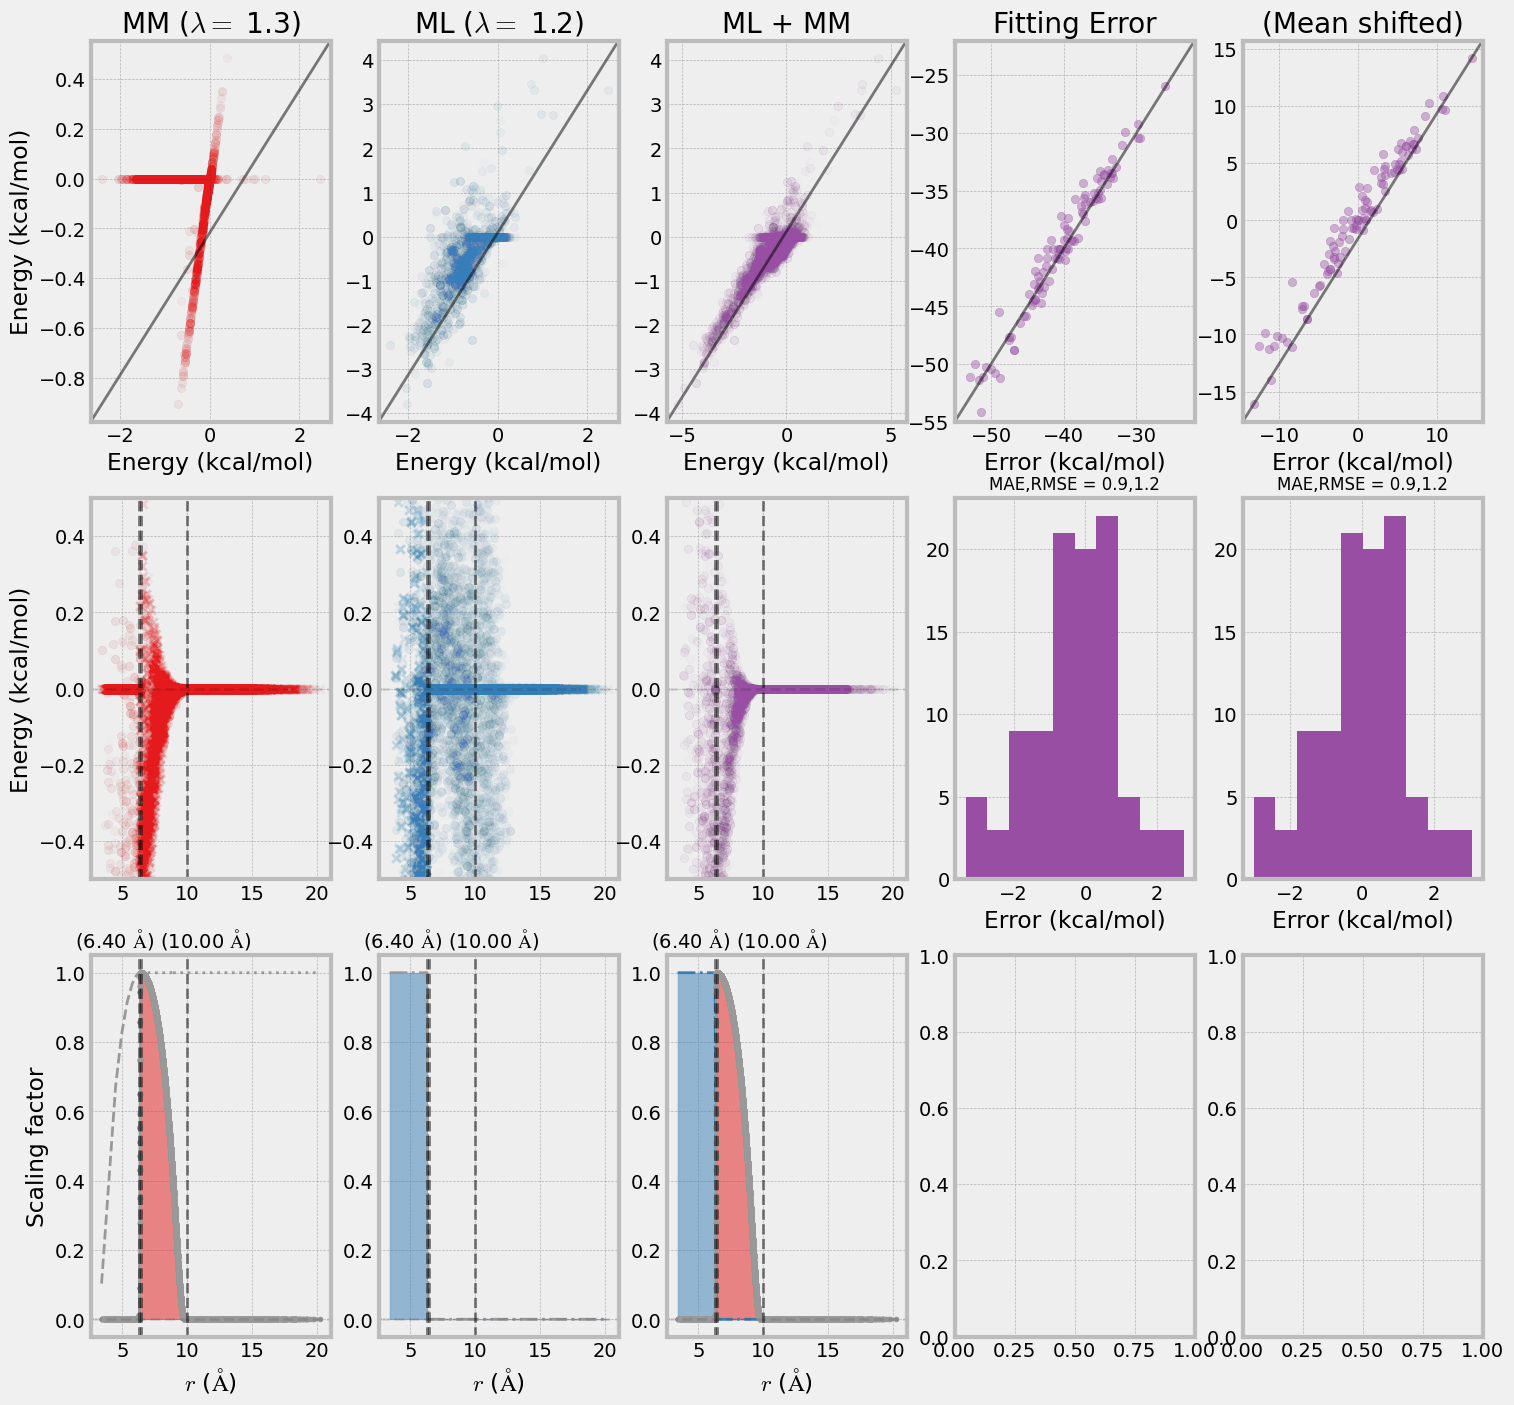

In [1231]:
_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = bestco, 
     MM_CUTOFF = 10, 
     BUFFER = bestbuff,
     MM_E_scale = bests1,
     ML_E_scale = bests2,
     E_SHIFT = 0,
    plot=True,
    )
_

In [1114]:
per_dimer_charmm_energies_np = per_dimer_ele_energies_np + per_dimer_evdw_energies_np

jnp.array(per_dimer_charmm_energies_np)

Array[100, 190] n=19000 (74Kb) x∈[-2.420, 2.456] μ=-0.240 σ=0.431 gpu:0

In [1140]:
# plt.hist(jnp.array(qm_E), bins=12)

In [1074]:
jnp.array(per_dimer_charmm_energies_np).reshape(100, 190).sum(axis=1)

Array[100] x∈[-56.722, -35.306] μ=-45.621 σ=4.704 gpu:0

In [1075]:
len(np.arange(1.2, 2.3, 0.1)), len(np.arange(5, 8, 0.2))

(11, 15)

In [1076]:
11*11*5*15

9075

In [1077]:
len(np.arange(1.3, 2.0, 0.01))

len(np.arange(1.95, 2.1, 0.001))**2

22801

In [1078]:
# scales = [0.1, 0.3, 0.6, 0.9, 1, 1.1, 1.4, 1.7, 1.9]
scales = scales1 = scales2 = np.arange(1.2, 2.3, 0.1) #[ 0.9, 1, 1.1, 1.4, 1.5, 1.7,  2.0, ]
# scales1 = np.arange(1.45, 2.1, 0.01)
# scales2 = np.arange(1.45, 2.1, 0.01)
# scales1 = np.arange(1.95, 2.1, 0.001)
# scales2 = np.arange(1.45, 1.55, 0.001)
buffers = [0.001, 0.1, 0.5, 0.9, 1, 2,]
best = 10000

for buff in buffers:
    for CO in np.arange(5, 8, 0.2):
        for s1 in scales1:
            for s2 in scales2:
                _ =plot(pair_cc_distances_per_dimer_np,
                    per_dimer_charmm_energies_np, 
                    per_dimer_ml_energies_np,
                     dif = 10**(-1), 
                     MM_CUTON = CO, 
                     MM_CUTOFF = 14, 
                     BUFFER = buff,
                     MM_E_scale = s1,
                     ML_E_scale = s2,
                     E_SHIFT = 0,
                      # plot=True,
                    )
                if _ < best:
                    best = _
                    print(s1, s2, CO, buff, _)
                    bests1 = s1
                    bests2 = s2
                    bestco = CO
                    bestbuff = buff

print("Done")
print("bests1", bests1)
print("bests2", bests2)
print("bestco", bestco)
print("bestbuff", bestbuff)

1.2 1.2 5.0 0.001 Array gpu:0 12.047
1.2 1.2 5.2 0.001 Array gpu:0 10.067
1.2 1.2 5.4 0.001 Array gpu:0 8.231
1.2 1.2 5.6000000000000005 0.001 Array gpu:0 6.543
1.2 1.2 5.800000000000001 0.001 Array gpu:0 3.982
1.2 1.2 6.000000000000001 0.001 Array gpu:0 2.783
1.2 1.2 6.200000000000001 0.001 Array gpu:0 1.634
1.2 1.2 6.400000000000001 0.001 Array gpu:0 1.252
1.3 1.2 6.400000000000001 0.001 Array gpu:0 1.205
Done
bests1 1.3
bests2 1.2
bestco 6.400000000000001
bestbuff 0.001


Array gpu:0 1.203

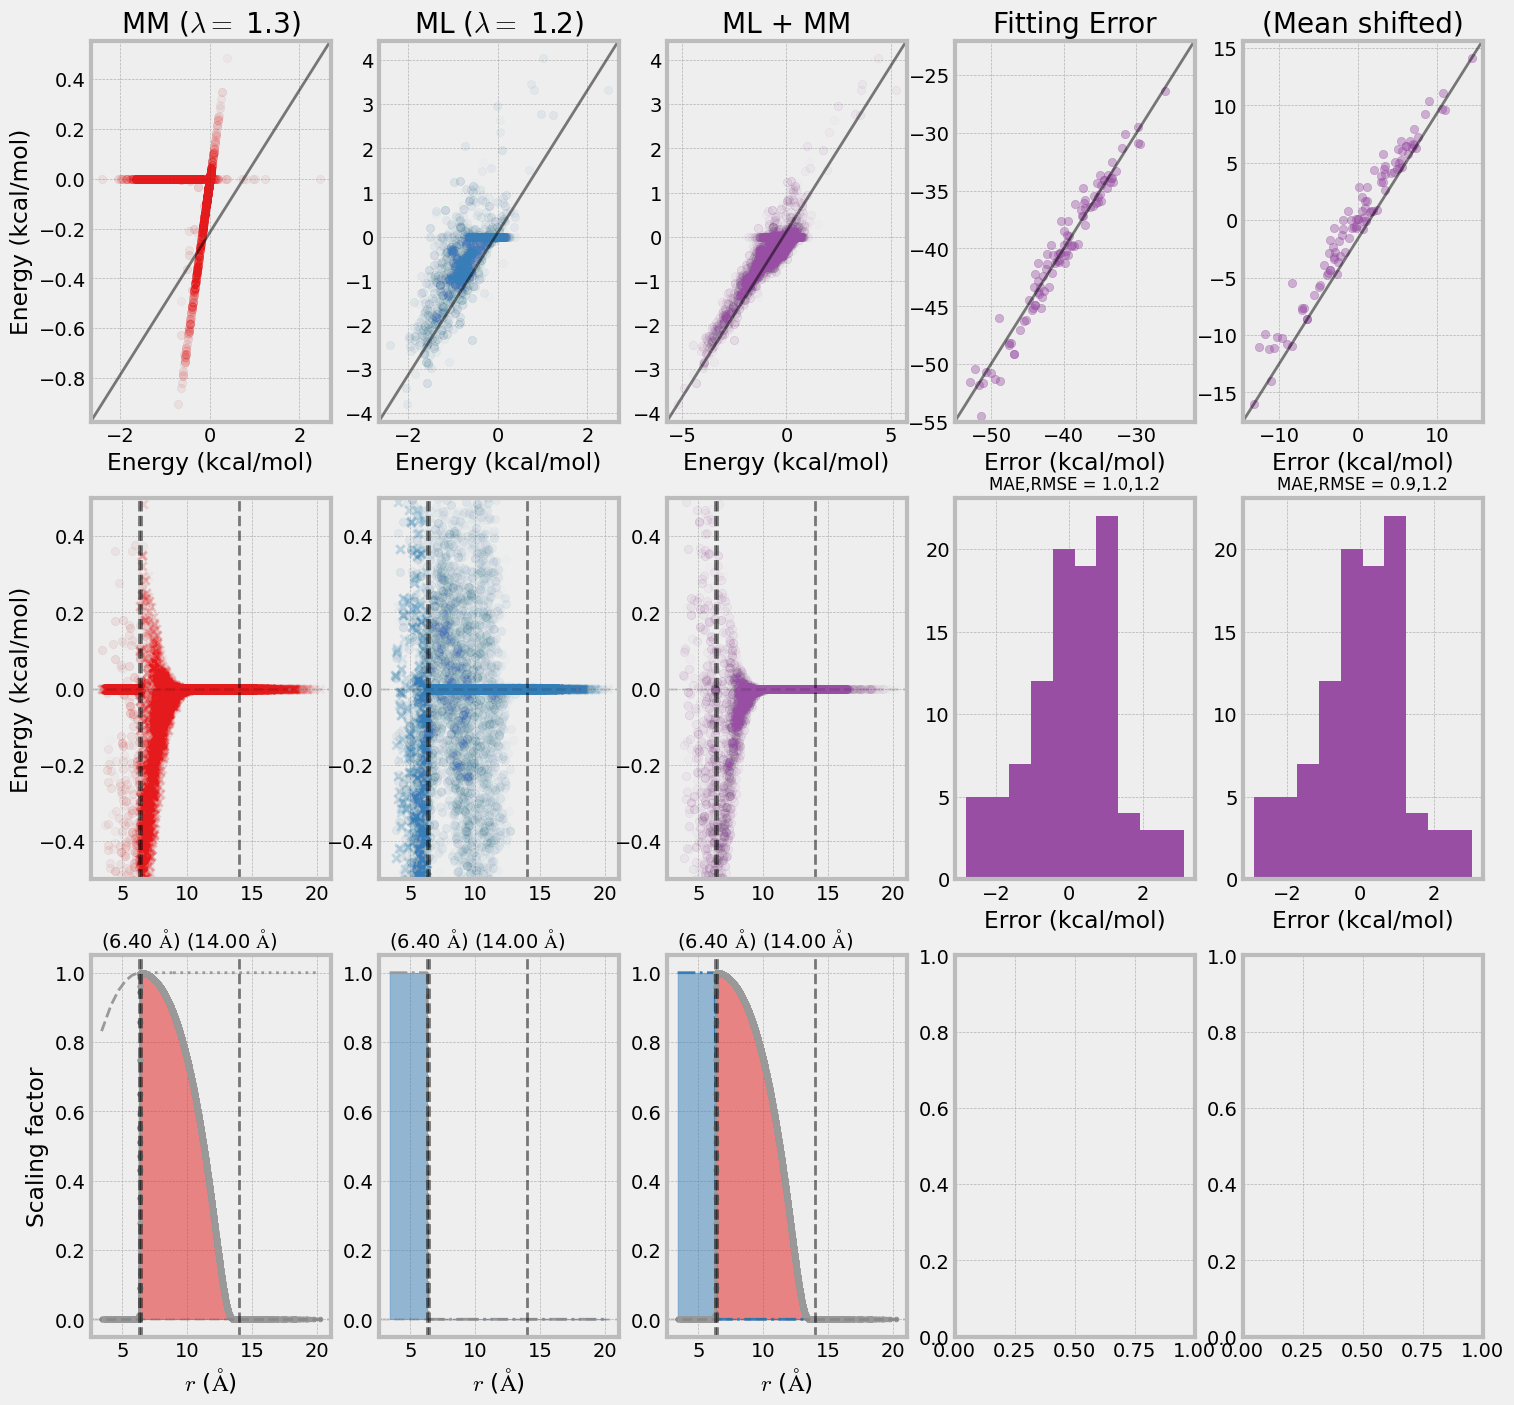

In [1232]:
# 1.9 1.4
_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = bestco, 
     MM_CUTOFF = 14, 
     BUFFER = bestbuff,
     MM_E_scale = bests1,
     ML_E_scale = bests2,
     E_SHIFT = 0,
    plot=True,
    )
_

Array gpu:0 1.626

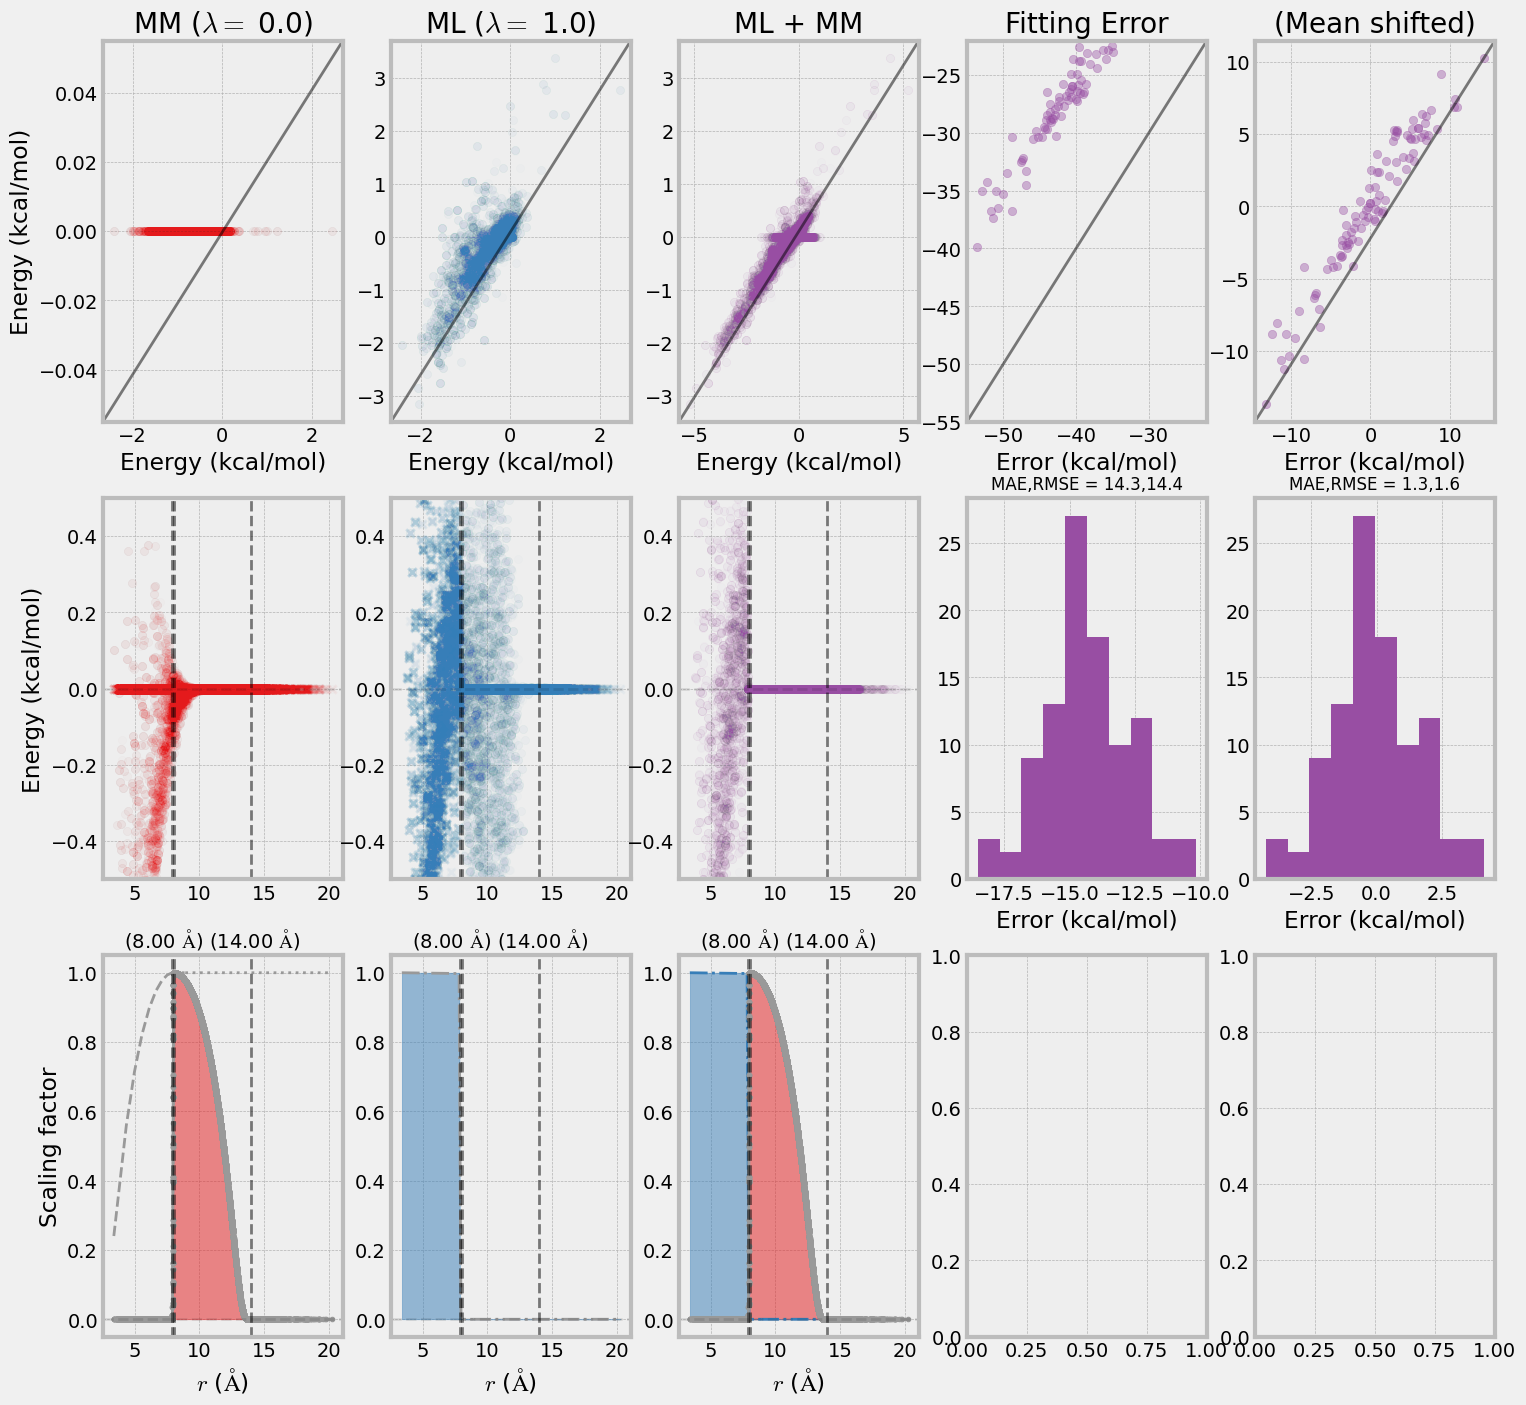

In [1233]:

_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = 8.0, 
     MM_CUTOFF = 14, 
     BUFFER = 0.1,
     MM_E_scale = 0,
     ML_E_scale = 1,
     E_SHIFT = 0,
     plot=True,
    )
_

Array gpu:0 2.981

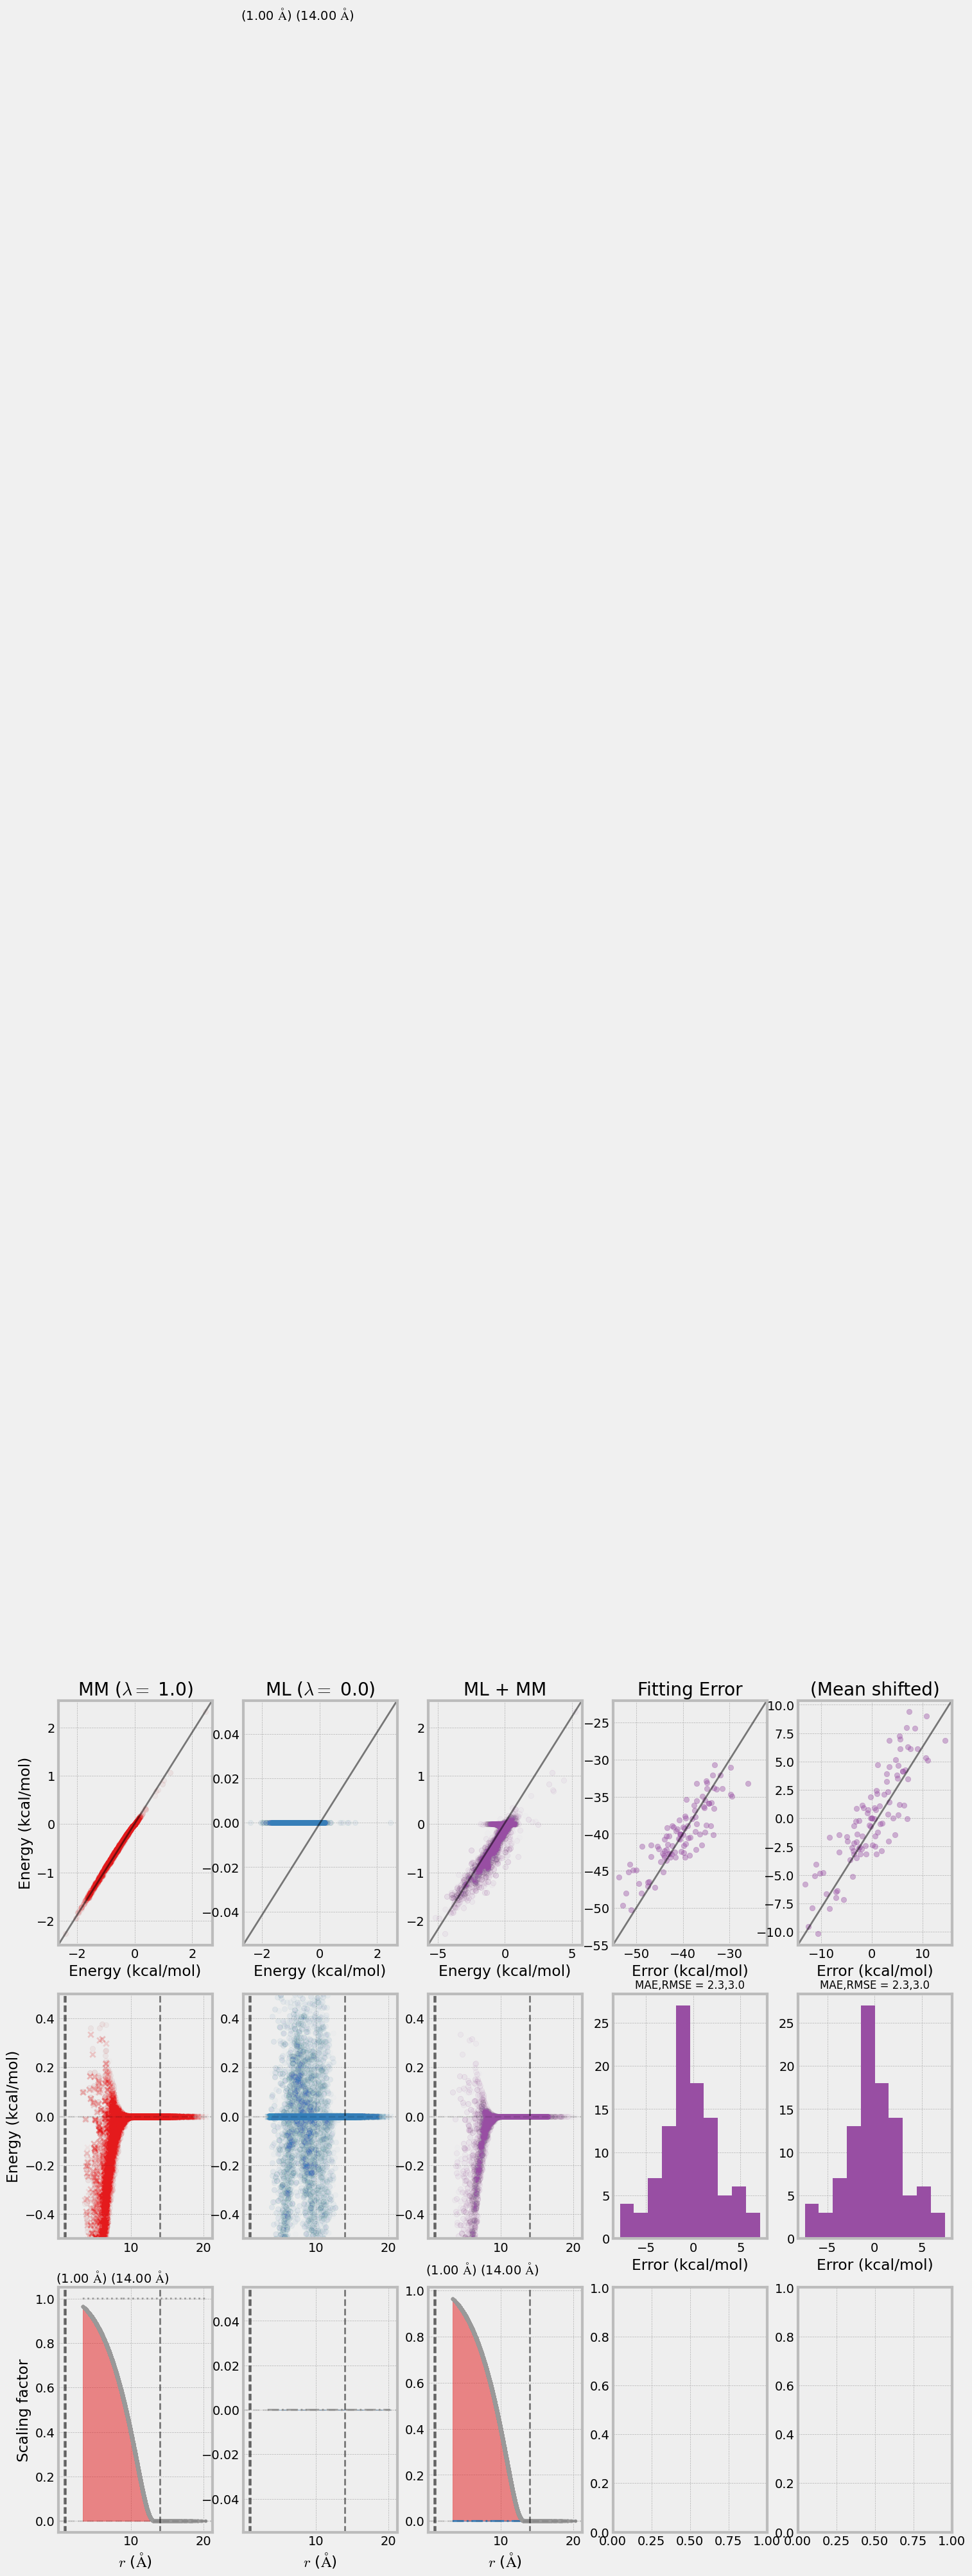

In [1234]:

_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 10**(-1), 
     MM_CUTON = 1.0, 
     MM_CUTOFF = 14, 
     BUFFER = 0.1,
     MM_E_scale = 1,
     ML_E_scale = 0,
     E_SHIFT = 0,
               plot=True,
    )
_

Array gpu:0 4.520

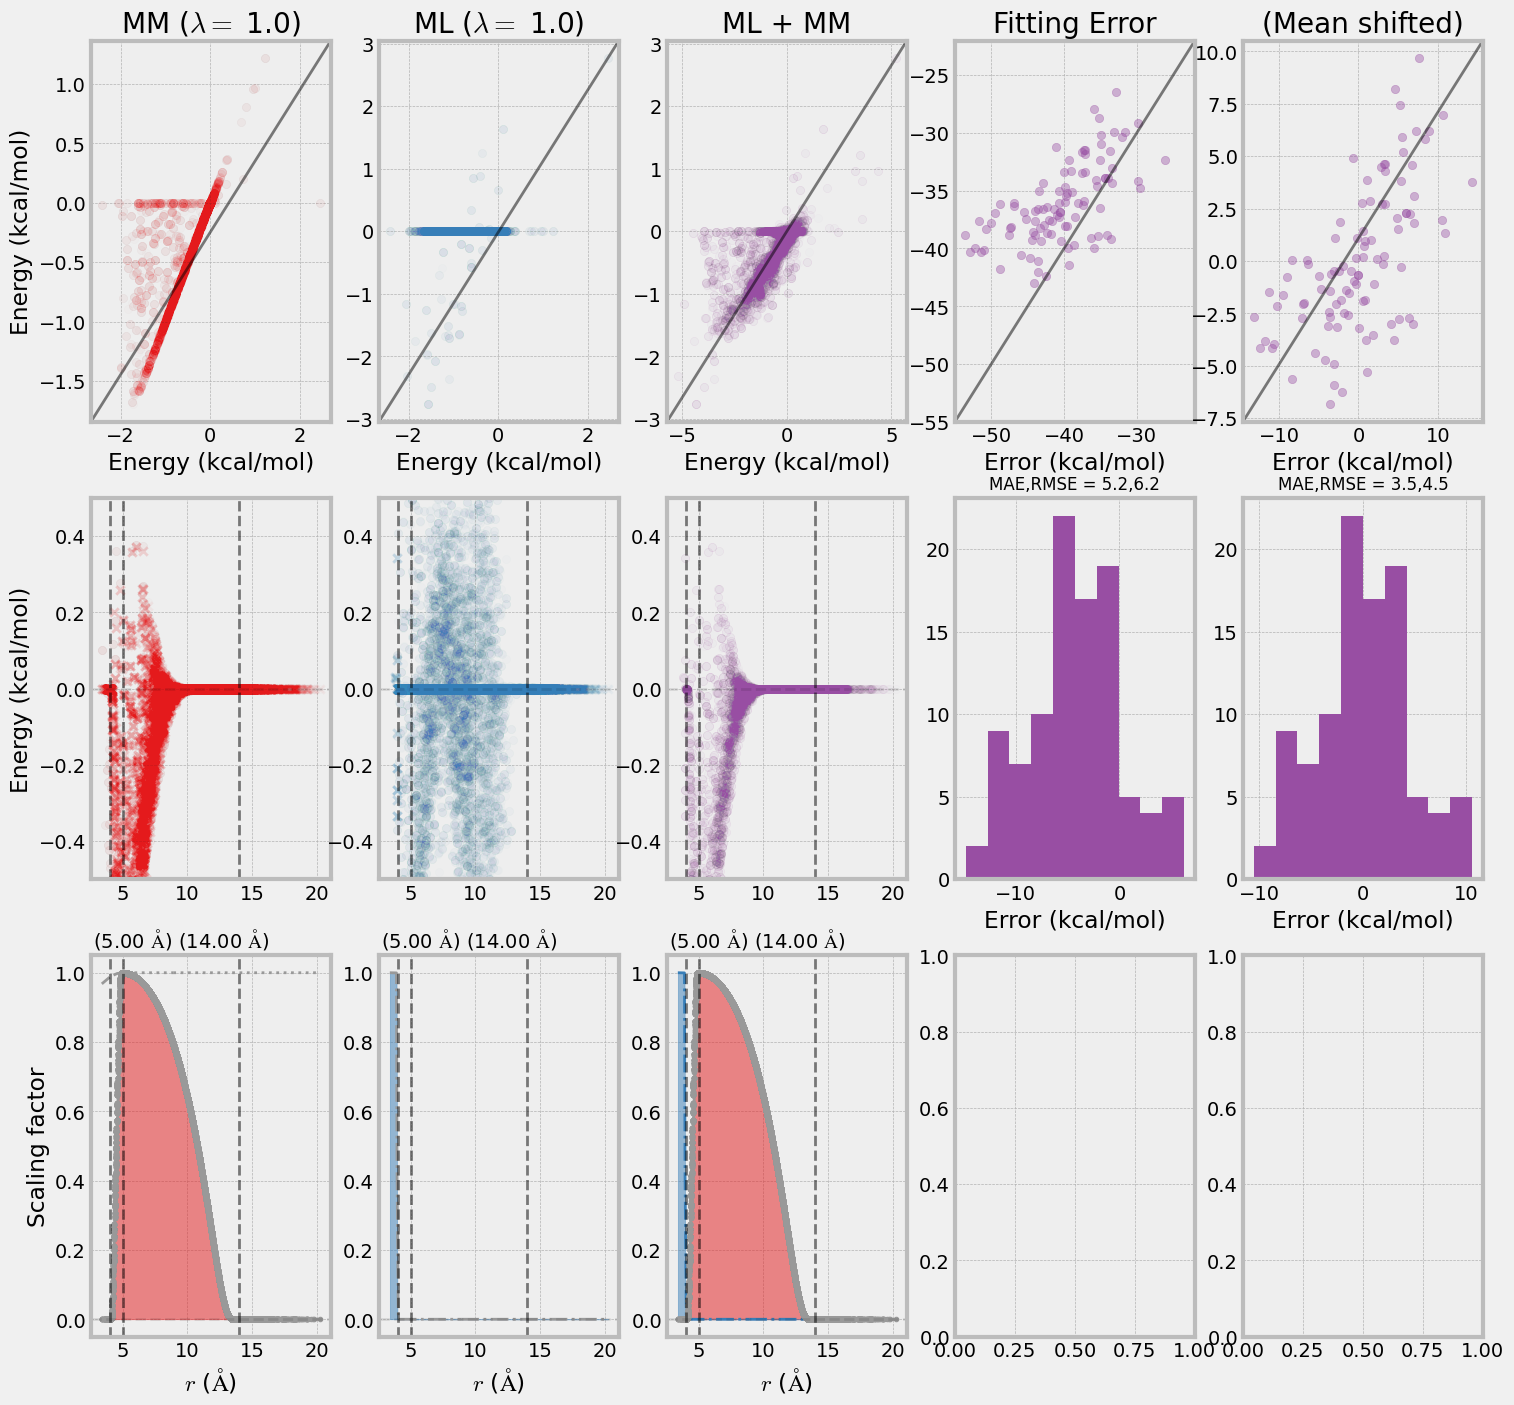

In [1235]:
_ = plot(pair_cc_distances_per_dimer_np,
    per_dimer_charmm_energies_np, 
    per_dimer_ml_energies_np,
     dif = 1, 
     MM_CUTON = 5.0, 
     MM_CUTOFF = 14, 
     BUFFER = 0.1,
     MM_E_scale=1,
     ML_E_scale = 1,
     E_SHIFT = 1,
      plot=True,
    )
_